In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from dataloader import *
from utils import *

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [ ]:
import warings
warnings.filterwarnings("ignore")

In [3]:
# Créer le DataLoader
train_dl = Sentinel2(csv_path=csv_path, split="train", RGB=False)
train_loader = DataLoader(train_dl, batch_size=4, shuffle=False)

images, masks = next(iter(train_loader))

Batch 0
Images shape: torch.Size([8, 12, 32, 32])
Masks shape: torch.Size([8, 1, 32, 32])


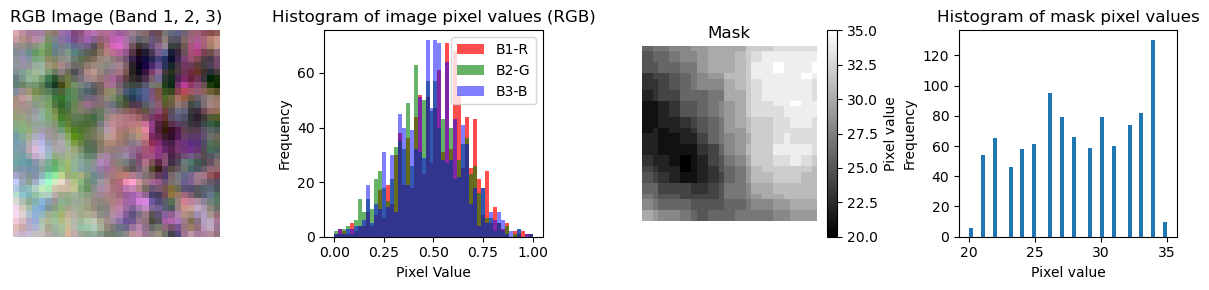

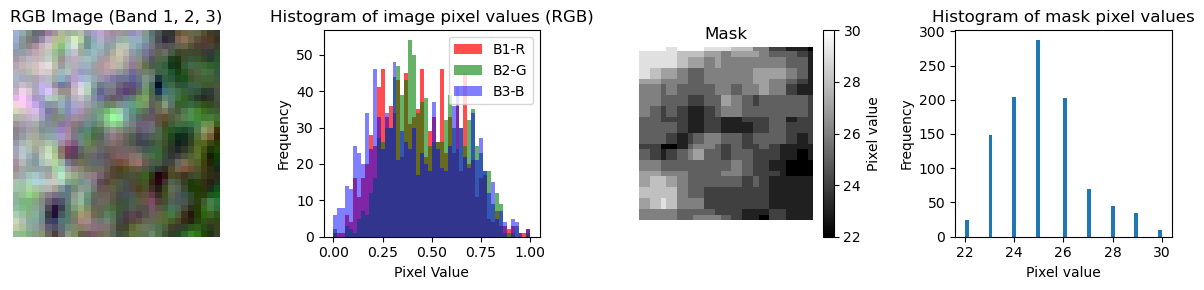

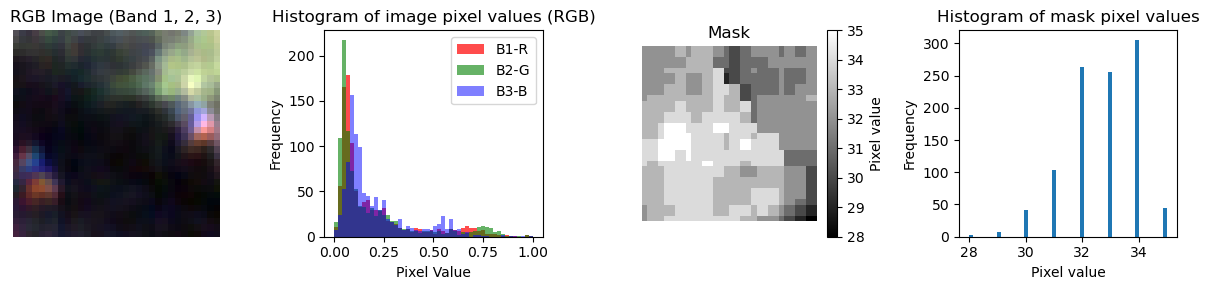

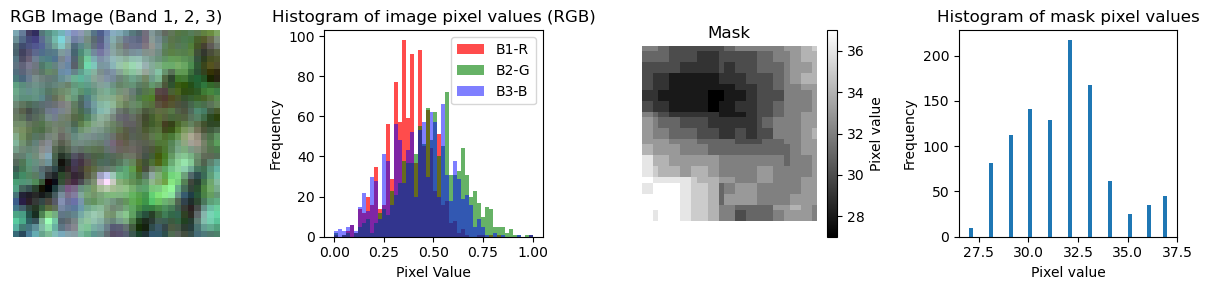

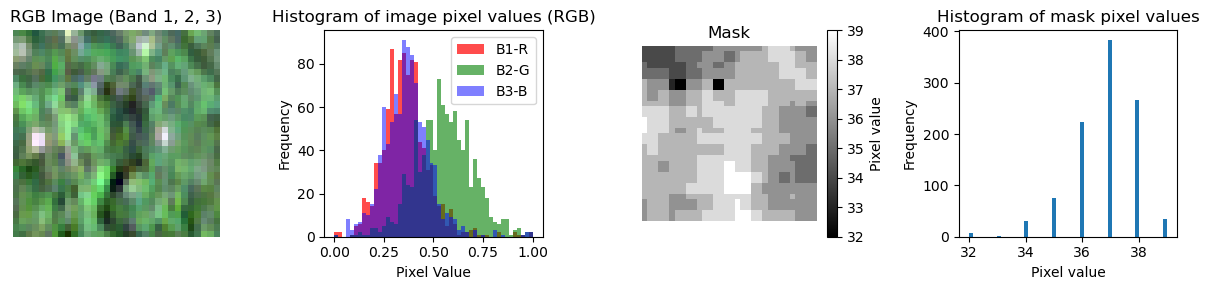

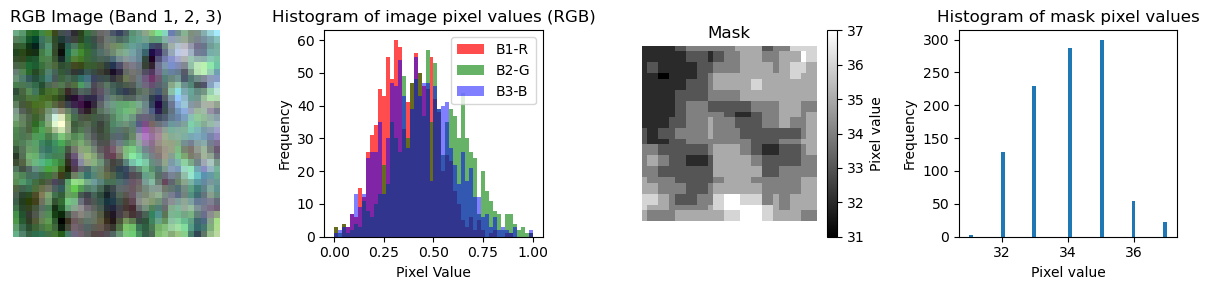

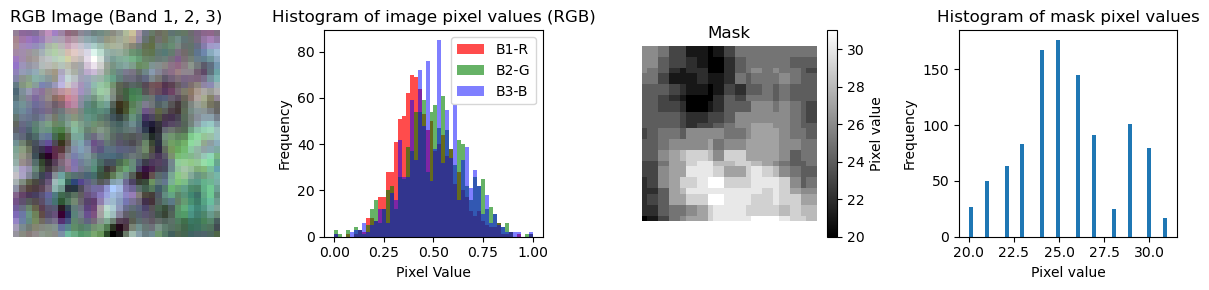

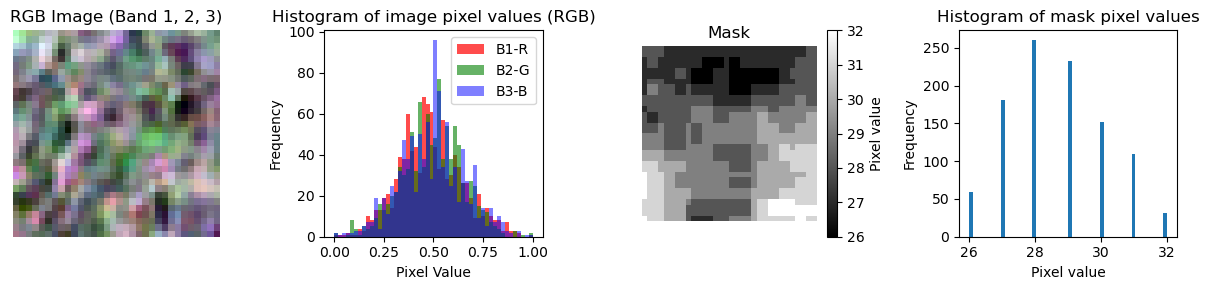

In [5]:
for i in range(0,images.shape[0]):
    image = images[i].numpy()
    mask = masks[i].numpy()
    show_image_histogram_mask(image, mask)

In [6]:
transforms_train = TransformCustom12(augmentations=[
  RandomHorizontalFlip(p=0.5),
  RandomVerticalFlip(p=0.5),
  RandomRotation(angles=(90,180,270), p=0.5)
])

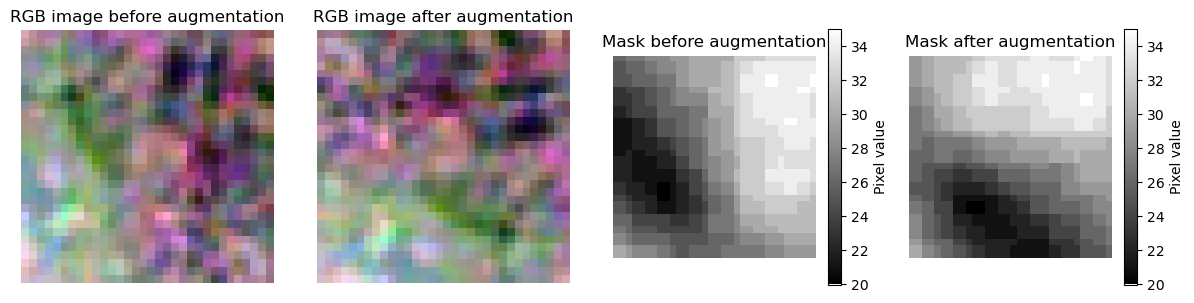

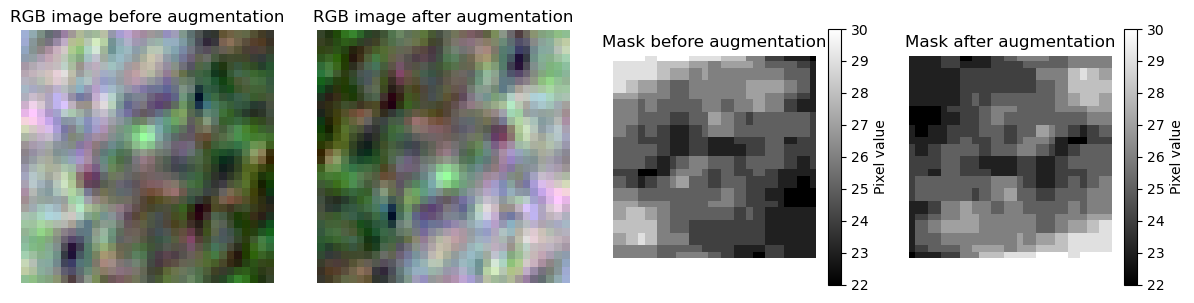

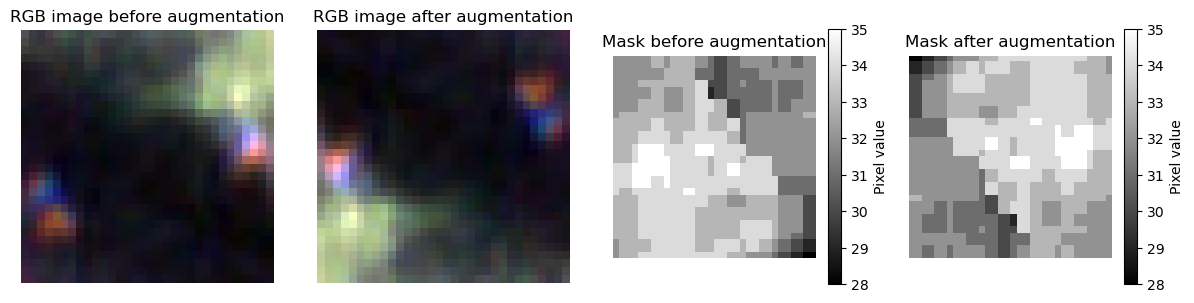

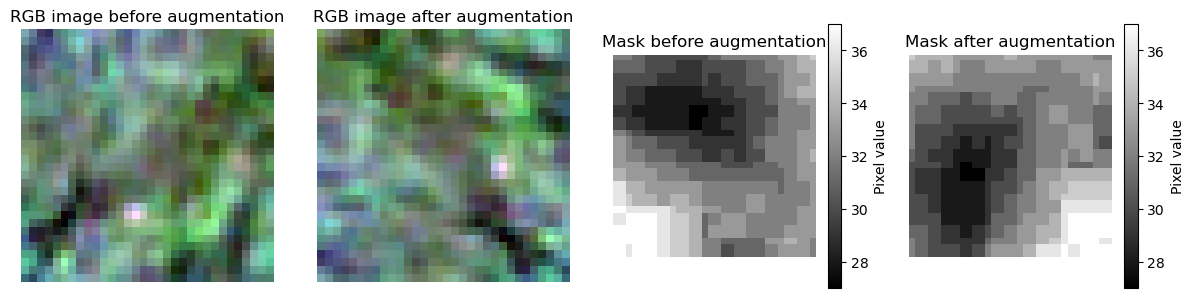

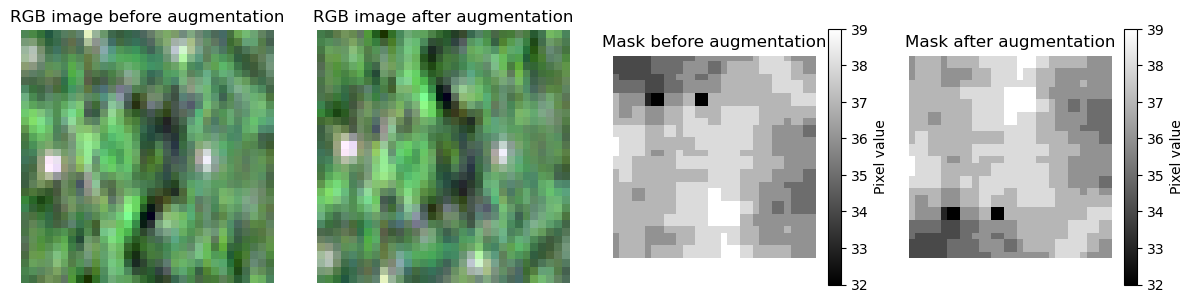

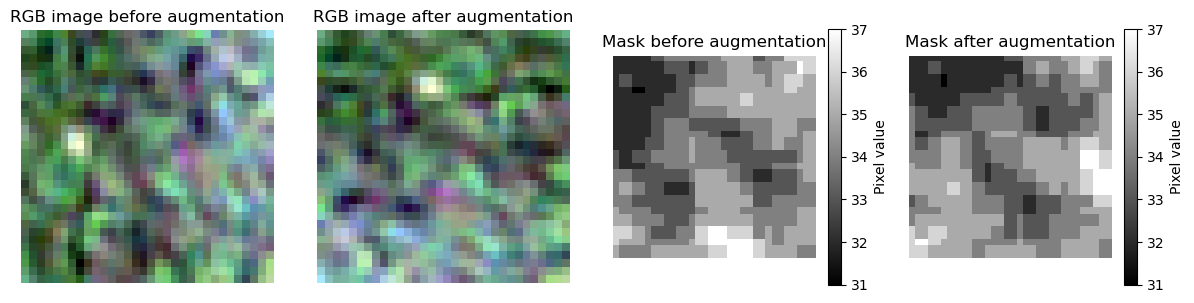

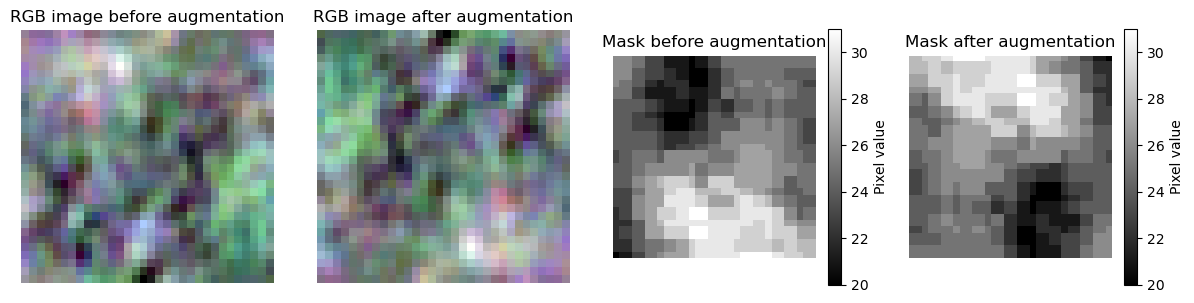

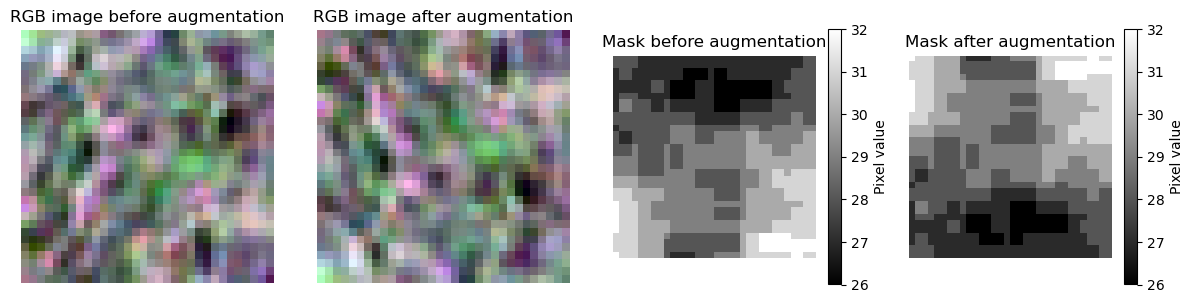

In [9]:
train_trandform_dl = Sentinel2(csv_path=csv_path, split="train",transform=transforms_train, RGB=False)
train_transform_loader = DataLoader(train_trandform_dl, batch_size=4, shuffle=False)

train_dl = Sentinel2(csv_path=csv_path, split="train",transform=None)
train_loader = DataLoader(train_dl, batch_size=4, shuffle=False)
 
images_before, masks_before = next(iter(train_loader))
images_after, masks_after = next(iter(train_transform_loader))

for i in range(0,images_before.shape[0]):
    image_before = images_before[i].numpy()
    mask_before = masks_before[i].numpy()

    image_after = images_after[i].numpy()
    mask_after = masks_after[i].numpy()

    show_before_after_augmentation(image_before, image_after, mask_before, mask_after)